# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics, test_dates
from my_functions import my_kfold_crossval_and_Hptunning, My_ML_prediction_on_test, scaler, consolidated_metrics_MSE, consolidated_plot_metrics

In [3]:
from especial_functions import feature_silver, integration_new_features_map, features_rows_train_silver

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Models Definition

In [4]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [5]:
my_gbr_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [15,10, 8, 12, 13, 7, 15, 15, 10, 7],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 30, 25, 25, 30, 27, 30, 22, 25, 26],
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_adab = GradientBoostingRegressor( n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='squared_error',
                                       max_depth = max_depth_param, min_samples_split = min_samples_split_param , max_features = max_features_param,
                                       min_samples_leaf = min_samples_leaf_param)
    my_gbr_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [6]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  [my_gbr_models[0]], frac = 0.75)

machine-1 is done
Wall time: 15min 7s


In [7]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

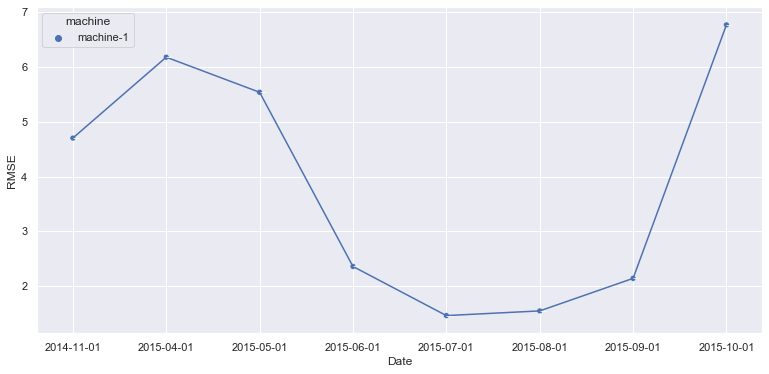

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [9]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,4.326609


### Kfold cross validation and hyper parameter tunning

In [10]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  my_gbr_models, frac = 0.50)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [11]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

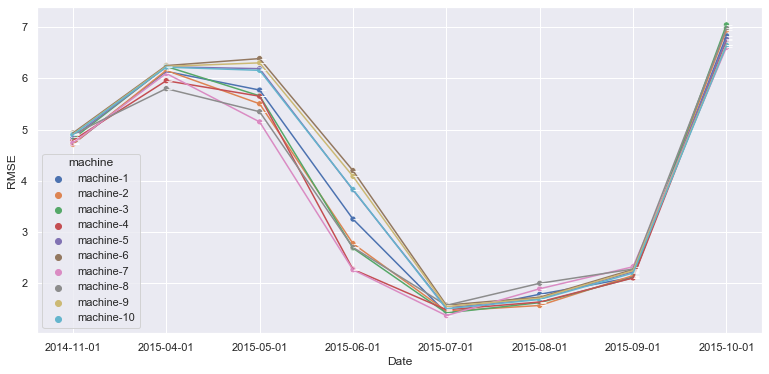

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [14]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
6,machine-7,4.242295
3,machine-4,4.308618
7,machine-8,4.371027
1,machine-2,4.390735
0,machine-1,4.451353
2,machine-3,4.452110
9,machine-10,4.561223
4,machine-5,4.592543
8,machine-9,4.624412
5,machine-6,4.655943


### Winner Prediction

In [15]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  [my_gbr_models[6]], frac = 1.0)

machine-1 is done


In [16]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

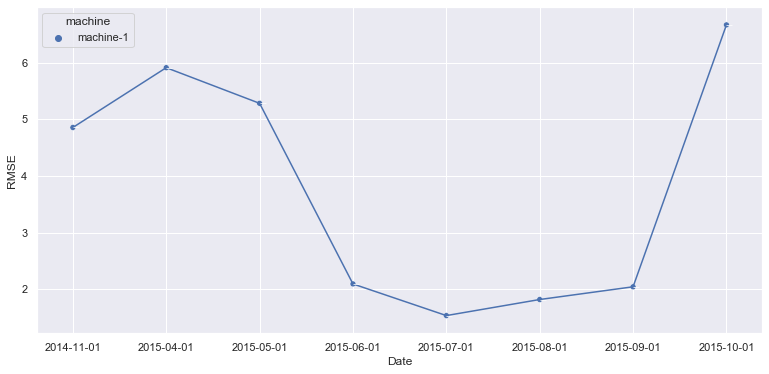

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

### Saving Results for Stacking

In [18]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_gradboost.csv',header = True, index = False)

----

### Stacking

In [5]:
preds_gradBoost = pd.read_csv('preds_stacking/preds_gradboost.csv').rename(columns = {'PredictedVar':'PredictedVar_gradBoost'})
preds_adaBoost = pd.read_csv('preds_stacking/preds_adaboost.csv').rename(columns = {'PredictedVar':'PredictedVar_adaBoost'})

In [6]:
columns_1 = ['Date','Sale','PredictedVar_gradBoost','RealValueVar','SaleL1M']
columns_2 = ['PredictedVar_adaBoost']

In [7]:
merge_preds = preds_gradBoost[columns_1].merge(preds_adaBoost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds['Date'] = pd.to_datetime(merge_preds.Date)
merge_preds['month'] = merge_preds.Date.dt.month

##### Train stacking data

In [8]:
my_features = ['PredictedVar_gradBoost','PredictedVar_adaBoost','month']
my_target = 'RealValueVar'

In [9]:
data_to_use = merge_preds[my_features + [my_target] + ['Sale','SaleL1M']].copy()

val_index = list(data_to_use[data_to_use.RealValueVar == 0].sample(frac = 0.05).index) + list(data_to_use[data_to_use.RealValueVar != 0].sample(frac = 0.35).index)
val_data = data_to_use[data_to_use.index.isin(val_index)]

train_data = data_to_use[~data_to_use.index.isin(val_index)]
train_index = list(train_data[train_data.RealValueVar == 0].sample(frac = 0.01).index) + list(train_data[train_data.RealValueVar != 0].sample(frac = 0.85).index)
train_data = train_data[train_data.index.isin(train_index)]

In [10]:
X_train = train_data[my_features]
Y_train = train_data[my_target]

X_val = val_data[my_features].copy()

In [11]:
stacker = GradientBoostingRegressor( max_depth = 15,n_estimators = 40, learning_rate = 0.0015, loss='squared_error', )
stacker.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.0015, max_depth=15, n_estimators=40)

In [12]:
Y_pred = stacker.predict(X_val)

In [13]:
val_data_v2 = val_data.copy()
val_data_v2['PredictedVar'] = Y_pred
val_data_v2['PredSale'] = val_data_v2['PredictedVar'] + val_data_v2['Sale']

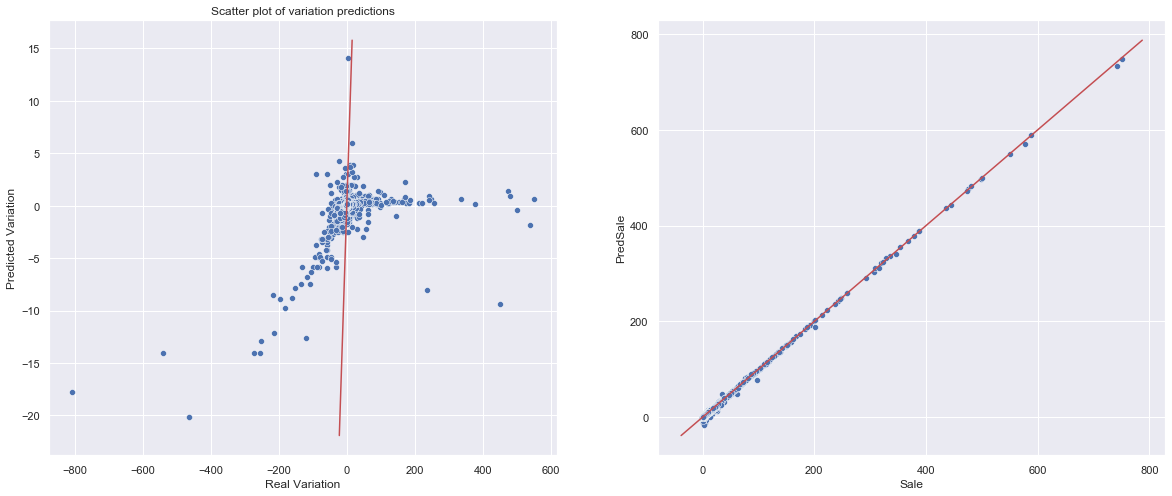

In [14]:
plot_prediction(val_data_v2)

In [15]:
mean_squared_error(val_data_v2['Sale'], val_data_v2['PredSale'])**(1/2)

0.23986245777263937

----

## Final Prediction

### Data

In [5]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [17]:
train_merge = merge_basic(daily_train, test)

In [18]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-08


In [19]:
wholedata_silver = convert_silver(train_merge)

In [20]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


In [21]:
### test preparation
test_data = test.copy()
test_data['SaleDateMY'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data = test_data.merge(items, on = 'item_id',how = 'left')
test_data = test_data.merge(categories, on= 'item_category_id', how = 'left')
test_data['item_cnt_day'] = np.nan
test_data['shopitem'] = test_data['shop_id'].astype('str') + '-' + test_data['item_id'].astype('str')
test_data = test_data[['SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']]

In [22]:
test_data.head()

,SaleDateMY,shop_id,item_id,item_category_id,item_category_name,item_cnt_day
0,2015-11-01,5,5037,19,Игры - PS3,NaN
1,2015-11-01,5,5320,55,Музыка - CD локального производства,NaN
2,2015-11-01,5,5233,19,Игры - PS3,NaN
3,2015-11-01,5,5232,23,Игры - XBOX 360,NaN
4,2015-11-01,5,5268,20,Игры - PS4,NaN


In [23]:
test_data.shape

(214200, 6)

In [24]:
date_val = datetime.datetime(2015, 11, 1)

In [25]:
train_full = completion_semi_gold(wholedata_silver)

In [26]:
train_feature, features_dictionary = feature_silver(train_full)

In [27]:
train_feature = integration_new_features_map(data = train_feature, dict_feature= features_dictionary) 

In [28]:
to_drop_columns = ['Date','Sale','SaleL1M']
numericals = ['L1M_L2M', 'L2M_L3M', 'L3M_L4M','L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'possCounts','maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12','month', 'maxSaleL1M', 'noVar', 'countNoVar', 'FlagShop','monthToPredict',
       'FlagCategory', 'SumBefExplotion', 'labeling', 'meanVarExploItem','meanVarExploShop', 'countMonth', 'medianVarL12', 'SeasonalVariation','HighVarL12' ]
categoricals = ['categVolume', 'categSale']
my_features = to_drop_columns + numericals + categoricals
my_target = 'L0M_L1M'
len(my_features) - 3

34

In [29]:
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, sample_1 = 0.55, sample_2 = 0.15, dates_back = 2)

In [30]:
my_columns_to_drops = ['noVar', 'categSale_A','labeling','categSale_D','categVolume_G','categVolume_F','categVolume_F','categVolume_H','Roll0count','categSale_C','categVolume_C','categVolume_D','FlagShop','maxSaleL1M']
train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
train_dummies = pd.get_dummies(train_selection[categoricals])
train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [31]:
final_features = list(train_dummies.columns) +  numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

### ML Training

In [32]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [33]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 40, min_samples_split = 10, min_samples_leaf = 12 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=90, learning_rate=0.002, loss='linear')
my_ABM.fit(X_train, Y_train)

Wall time: 9min 14s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=40,
                                                       max_features=25,
                                                       min_samples_leaf=12,
                                                       min_samples_split=10),
                  learning_rate=0.002, n_estimators=90)

In [34]:
%%time
my_adab = GradientBoostingRegressor( n_estimators = 150, learning_rate = 0.15, loss='squared_error', max_depth = 15, min_samples_split = 3 , 
                                    max_features = 30, min_samples_leaf = 3)
my_adab.fit(X_train, Y_train)

Wall time: 8min 27s


GradientBoostingRegressor(learning_rate=0.15, max_depth=15, max_features=30,
                          min_samples_leaf=3, min_samples_split=3,
                          n_estimators=150)

<b> prepare test to predict

In [35]:
full_valandtrain = preparing_to_predict(val_data = test_data, train_data = wholedata_silver)
full_valandtrain = completion_semi_gold(full_valandtrain)

In [36]:
valandtrain_feature , _ = feature_silver(full_valandtrain)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary) 

In [37]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1, validation = date_val) 

In [38]:
val_selection.shape

(214200, 38)

In [39]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
val_dummies = pd.get_dummies(val_selection[categoricals])
val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)

In [40]:
X_val = val_scaled_full[final_features]

In [41]:
Y_pred_adaboost = my_ABM.predict(X_val)
Y_pred_gradboost = my_adab.predict(X_val)

In [42]:
predicted_val_adaboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_adaboost)
predicted_val_gradboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_gradboost)

In [48]:
my_lm_adaboost = consolidation_prediction(data = val_selection, prediction = predicted_val_adaboost.L0M_L1M.values).rename(columns = {'PredictedVar':'PredictedVar_adaBoost'})
my_lm_gradboost = consolidation_prediction(data = val_selection, prediction = predicted_val_gradboost.L0M_L1M.values).rename(columns = {'PredictedVar':'PredictedVar_gradBoost'})

In [51]:
merge_preds_val = my_lm_gradboost[columns_1].merge(my_lm_adaboost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds_val['Date'] = pd.to_datetime(merge_preds_val.Date)
merge_preds_val['month'] = merge_preds_val.Date.dt.month

In [53]:
my_features = ['PredictedVar_gradBoost','PredictedVar_adaBoost','month']
my_target = 'RealValueVar'

In [58]:
X_val = merge_preds_val[my_features].copy()

In [59]:
Y_pred = stacker.predict(X_val)

In [60]:
val_data_v2 = merge_preds_val.copy()
val_data_v2['PredictedVar'] = Y_pred
val_data_v2['PredSale'] = val_data_v2['PredictedVar'] + val_data_v2['Sale']

In [62]:
val_data_v2.to_csv('final_prediction.csv',header = True, index = False)

#### Continue.....

In [6]:
val_data_v2 = pd.read_csv('final_prediction.csv')

In [11]:
test['Prediction'] = val_data_v2.PredSale.values
test['item_cnt_month'] = np.where(test['Prediction'] < 0 ,0 ,
                        np.where(test['Prediction'] > 20, 20, test['Prediction']))

In [12]:
test.head()

,ID,shop_id,item_id,Prediction,item_cnt_month
0,0,5,5037,0.118689,0.118689
1,1,5,5320,0.051215,0.051215
2,2,5,5233,0.125221,0.125221
3,3,5,5232,0.142891,0.142891
4,4,5,5268,0.106339,0.106339


In [14]:
test.item_cnt_month.max(), test.item_cnt_month.min()

(14.06531452748428, 0.0)

In [15]:
test[['ID','item_cnt_month']].to_csv('miguel_prediction.csv',index = False, header = True)

This result got 1.21 and 1.23